## E18 - 뉴스 요약봇 만들기

##### 텍스트 요약

긴 길이의 문서에서 핵심 내용만 간추려서 요약한 문장으로 변환하는 것   
요약시 정보의 손실이 최소화되어야 한다   
추출적 요약과 추상적 요약으로 접근할 수 있다.   

###### 추출적 요약
원문에서 문장들을 추출하여 요약하는 방식.   
문장 중에서 요약문에 들어갈 핵심문장을 구별한다는 의미에서 문장 분류(text classification)의 문제라고 볼 수도 있다.   
10개의 문장이 있을 경우 3개의 문장을 추출하여 요약문을 만든다고 볼 수 있으며 연결된 3개의 문장이 자연스럽지 않을 수 있다.   
https://www.aclweb.org/anthology/W04-3252.pdf   
전통적인 머신 러닝 방식에 속하는 텍스트랭크라는 알고리즘을 사용한다.
대표적인 예로 네이버 뉴스 서비스에 있는 요약봇 기능이다.   

###### 추상적 요약
원문으로부터 요약된 새로운 문장을 생성하는 방식.   
자연어 생성(Netural language generation)

###### 텍스트 요약 훈련하기
seq2seq   
두 개의 RNN을 사용하여 입력 시퀀스로부터 출력 시퀀스를 생성하는 자연어 생성 모델.   
첫번째 RNN, 인코더을 통해 하나의 고정된 벡터로 변환, 문맥 정보을 가진 벡터, context vector   
두번째 RNN, 디코더는 context vector을 전달받아 단어를 하나씩 생성하여 요약 문장을 만들어낸다.   

이번에서 RNN이 아니라 LSTM를 사용한다.    
LSTM의 특징은 다음 time step의 셀에 hidden state와 cell state도 같이 전달하는 점이다.   

시작 토큰과 종료 토큰이 필요하다. 전처리를 해야 한다.   

새로운 매커니즘, 어텐션 매커니즘 이용   
마지막 time step의 hidden state는 전달한 context vector로서 이미 입력 시퀀스의 정보가 많이 소실된 상태다.   
어텐션은 인코더의 모든 단계의 hidden state의 정보를 context vector에 반영한다.    
하지만 모든 hidden state가 동일한 비중으로 반영되지 않고   
현재 디코더의 time step을 예측할 때 인코더의 각 step이 얼마나 영향을 미치는지에 따른 가중합으로 계산한다.   
예) 0.2h1+0.3h2+0.1h3+0.15h4+0.25h5   
그래서 디코더의 각 step마다 그 가중치의 합은 달라진다.   
의문) 인코더가 진행되면서 각 단계의 context vector는 매번 바뀌나?  

1. seq2seq를 사용
2. LSTM을 사용, hidden state와 cell state도 사용
3. 디코더의 예측 시퀀스 앞뒤로 토큰 추가 sos, eos
4. seq2seq을 실행하면 디코더는 시작 토큰을 입력받아서 예측을 시작
5. seq2seq 기본 모델이 아니라 어텐션 매커니즘 사용하여 인코더의 hidden state의 중요도에 따라 context vector 계산
6. 계산된 context vector을 이용하여 다음 단어을 예측한다.

###### 데이터 준비하기
캐글에서 제공된 아마존 리뷰 데이터셋 사용   
https://www.kaggle.com/snap/amazon-fine-food-reviews   
reviews.csv 파일(286.97MB)

NLTK의 불용어 사용   
NLTK(Natural Language Toolkit): 100여개의 불용어가 미리 정의되어 있다.   
pip install nltk

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aiffel0042/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Reviews.csv: 568,454개의 샘플

data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows = 100000)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 100000


In [3]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
# 훈련할 summary, text열만 분리하여 저장하기

data = data[['Text','Summary']]
data.head()

#랜덤한 15개 샘플 출력
data.sample(15)

,Text,Summary
41619,BIG DISAPPOINTMENT !!!!! I'm so glad that Amaz...,Tastes Very Strong and Harsh
37492,These bars are amazing when you look at the st...,Delicious flavor
17249,I used to drink Crystal Light over 10 years ag...,They have definitely changed things!
9120,this product is great tasting and you don't ev...,great taste
23907,I have a bag of Popchips everyday with lunch. ...,"Popchips 5 Stars, Chili Lime Flavor 3 Stars"
10655,All I can say is that our two dogs love these ...,Canine Testimonial
53905,I don't see how anyone can go wrong with any o...,May Ploy Curry Sauce - Get Sum
20627,Makes my dog's poo smell like roses! No just ...,Super Dooooo per
30273,"We have tried numerous recipes, but this makes...",Best GF bread we've found yet!
87557,This is by far the best cheese popcorn I have ...,Unbelievably Cheesy!


In [5]:
# 데이터 전처리하기
# 1. 중복 샘플과 Null값인 샘플 제거하기

print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


In [6]:
data.drop_duplicates(subset = ['Text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 88426


In [7]:
# Null값 확인하기

print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [8]:
# dropna(): null값인 행 제거

data.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 88425


In [9]:
# 텍스트 정규화
# it'll == it will, mustn't == must not 이런 표현은 같은 의미이므로 같은 표현으로 통일시켜주는
# 텍스트 정규화가 필요하다.
# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                        "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                        "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                        "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                        "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                        "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                        "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                        "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                        "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                        "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                        "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                        "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                        "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                        "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                        "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                        "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                        "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                        "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                        "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                        "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                        "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                        "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                        "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [10]:
# 불용어 제거하기

print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [11]:
#데이터 전처리 함수

# text 전처리시에만 사용하고 summary에는 사용하지 않음.
# summary는 이미 요약된 단어들로 이루어졌기 때문에 그대로 둠으로써 의미가 잘 나타나도록 한다.

def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"', '', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b", "",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [12]:
# 전처리가 제대로 되는지 확인하기

temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [13]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [15]:
clean_summary = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

clean_summary[:5]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy']

In [16]:
# 전처리 과정에서 문장의 단어가 모두 제거될 수도 있으므로 빈 샘플 확인하기
# 만약 있다면 null값을 대체하기

data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [17]:
data.isnull().sum()

Text        0
Summary    70
dtype: int64

In [18]:
# 전처리 과정에 모든 단어가 제거된 샘플은 제거하기

data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))#데이터 전처리 함수

전체 샘플수 : 88355


텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


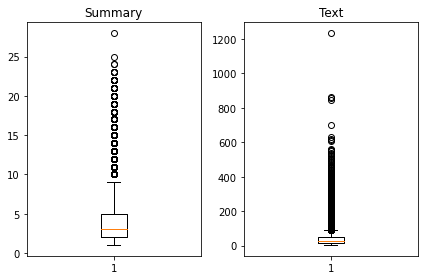

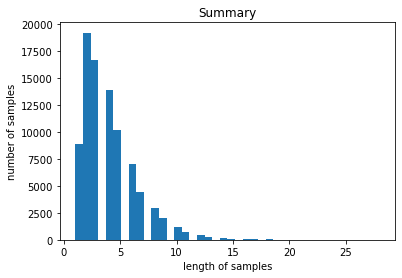

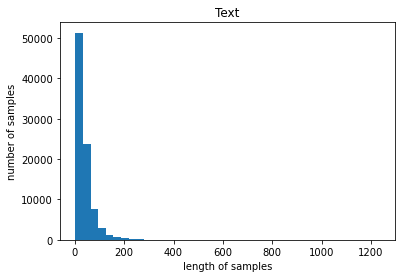

In [19]:
# 샘플의 최소, 최대, 평균을 구하고 길이 분포 시각화하기

# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
# 적절한 최대 길이 정하기

text_max_len = 50
summary_max_len = 8

In [21]:
# 최대 길이에 속한 데이터를 전체 데이터의 몇%에 해당할까?

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [22]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


In [23]:
# 최대 길이보다 긴 데이터는 자르지 않고 제외시키는 방법으로 전처리 하기

data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 65818


In [24]:
# 디코더의 입력과 레이블에 시작토큰과 종료토큰 추가하기
# 디코더 입력에 해당하면서 시작토큰이 있으면 decoder_input
# 디코더 출력에 해당하면서 종료토큰이 있으면 decoder_target

# summary 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


In [25]:
# 인코더의 입력, 디코더의 입력과 레이블을 numpy 타입으로 변경 저장

encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [26]:
# 데이터 섞기

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[65047 54193 36829 ... 16006 38865 14736]


In [27]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [28]:
# 훈련 데이터와 테스트 데이터 분리하기 8:2

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 13163


In [29]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


##### 단어 집합(vocaburary) 만들기

In [30]:
# 텍스트를 연산이 가능하도록 정수로 바꾸기
# 각 단어에 고유한 정수를 부여하기(맵핑하기), 단어 집합 만들기

src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [31]:
# 단어 집합은 src_tokenizer.word_index에 저장된다.
# 등장 빈도수가 7회 미만인 단어는 제외하기
# src_tokenizer.word_counts.items()에 단어와 빈도 수가 저장되어 있다.

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31988
등장 빈도가 6번 이하인 희귀 단어의 수: 23746
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8242
단어 집합에서 희귀 단어의 비율: 74.23408778291859
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.381203202872192


In [32]:
# 빈도수가 6회 이하인 단어는 제외하고 단어 집합 크기를 8000으로 제한
# 토크나이저 정의 시 크기를 지정하면 된다.

src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [33]:
# texts_to_sequences(): 생성된 단어 집합에 기반하여 입력된 텍스트의 단어들을 모두 정수로 변환시킨다.

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1452, 155, 90, 2, 543, 7672, 2459, 2968, 44, 190, 7673, 1132, 3402, 1197, 2184, 946, 7213, 279, 245, 44, 322, 381, 1, 42, 35, 361, 6476, 1205, 420, 7, 540, 54, 517, 4081, 318, 1274, 137, 1117, 4654, 344, 3989, 311, 2208, 10, 22], [1211, 9, 3358, 3254, 5651, 156, 587, 137, 3599, 111, 4399, 502, 486, 9, 486, 7, 743, 335], [654, 296, 7674, 246, 2626, 348, 2093, 1278, 2626, 155, 157, 3671, 463, 202, 1259, 18, 3600, 13, 824, 2480, 2626, 124, 287, 337, 568, 7, 246, 1613, 348, 5, 1, 165, 129, 755, 881, 713, 476, 730]]


In [34]:
# summary 데이터도 동일하게 진행

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [35]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10475
등장 빈도가 5번 이하인 희귀 단어의 수: 8105
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2370
단어 집합에서 희귀 단어의 비율: 77.3747016706444
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.89089561436396


In [36]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 3, 16, 388, 131], [1, 157, 27, 19, 384], [1, 69, 402], [1, 75, 23, 5, 8, 528], [1, 385, 215, 497, 9, 85]]
target
decoder  [[3, 16, 388, 131, 2], [157, 27, 19, 384, 2], [69, 402, 2], [75, 23, 5, 8, 528, 2], [385, 215, 497, 9, 85, 2]]


In [37]:
# 패딩을 추가하기 전에 단어 집합을 각각 8000개, 2000개로 제한하면서 빈 데이터가 나올 수 있다.
# text 데이터 보다는 summary 데이터에서 많이 나올 것이다.
# decoder는 이전에 토큰을 추가했으므로 빈 데이터는 길이가 1이 나올 것이다.

drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1294
삭제할 테스트 데이터의 개수 : 325
훈련 데이터의 개수 : 51361
훈련 레이블의 개수 : 51361
테스트 데이터의 개수 : 12838
테스트 레이블의 개수 : 12838


In [38]:
# 서로 다른 길이를 가진 샘플들의 길이는 맞추기 위해 패딩 처리를 한다.

encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

##### 모델 설계하기

In [39]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# hidden_size는 LSTM의 뉴론 갯수
# 3개의 LSTM층은 모델의 복잡도를 높여서 모델의 용량을 높인 것이다.
# 인코더에서 나온 출력 벡터를 디코더로 보낸다.

In [40]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

# initial_state는 인코더의 hidden state와 cell state 값이다.

In [41]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 디코더의 출력은 tar_vocab에서 하나를 선택하는 분류의 문제이므로 소프트맥스를 사용한다.

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [42]:
# 어텐션 매커니즘 적용하기
# 이미 구현된 어텐션 함수를 가져와서 디코더 출력층에 겹할하기
# 깃허브에서 어텐션 함수 다운로드 하기

urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer


In [43]:
# 디코더의 출력층 수정하기

# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [44]:
# 모델 훈련하기

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

# EarlyStopping: 특정 조건이 충족되면 모델의 훈련을 멈추는 역할
# val_loss를 모니터링하다가 val_loss가 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습이 종료된다.


Epoch 1/50
201/201 [==============================] - 201s 998ms/step - loss: 2.7071 - val_loss: 2.4194
Epoch 2/50
201/201 [==============================] - 203s 1s/step - loss: 2.3707 - val_loss: 2.2756
Epoch 3/50
201/201 [==============================] - 202s 1s/step - loss: 2.2276 - val_loss: 2.1509
Epoch 4/50
201/201 [==============================] - 203s 1s/step - loss: 2.1136 - val_loss: 2.0760
Epoch 5/50
201/201 [==============================] - 207s 1s/step - loss: 2.0322 - val_loss: 2.0239
Epoch 6/50
201/201 [==============================] - 196s 977ms/step - loss: 1.9691 - val_loss: 1.9876
Epoch 7/50
201/201 [==============================] - 195s 968ms/step - loss: 1.9190 - val_loss: 1.9555
Epoch 8/50
201/201 [==============================] - 201s 1000ms/step - loss: 1.8741 - val_loss: 1.9296
Epoch 9/50
201/201 [==============================] - 197s 982ms/step - loss: 1.8316 - val_loss: 1.9113
Epoch 10/50
201/201 [==============================] - 196s 976ms/step - lo

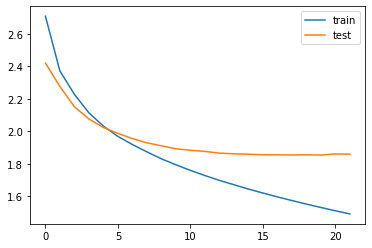

In [45]:
# 손실 과정을 시각화하기

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [46]:
# 인퍼런스 모델 구현하기
# 정수 데이터를 실제 데이터로 복원하기 위해

src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [47]:
# 훈련 단계:
# 정답 문장을 디코더에 입력하면 디코더에서 출력하는 문장과 한꺼번에 비교 가능, 인코더와 디코더 통합 설계
# 인퍼런스 단계(생성 단계):
# 생성될 문장 길이만큼 디코더가 반복 수행, 인코더와 디코더 분리 설계

# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [48]:
# 어텐션 매커니즘을 사용한 출력층 설계

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [49]:
# 단어 시퀀스를 생성하는 함수

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [50]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [51]:
# 테스트 데이터 50개 샘플에 대해 실제 데이터와 예측된 데이터를 비교하기

for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : let us say five us really enjoy swedish fish usually gone matter days however bought pack christmas still half pack left 
실제 요약 : these actually last in this house 
예측 요약 :  great product


원문 : chill switch kiwi berry pour pretty wine glass relax enjoy repeat switch kiwi berry pleasing color fruity taste enough carbonation experience 
실제 요약 : my throat 
예측 요약 :  good


원문 : gotten flavor larabar grocery store loved fact reason purchased amazon cost per unit much lower peanut butter cookie bar grocery store moist delicious bars received amazon taste stale dry crumbly expiration date understand would way reordering larabars amazon 
실제 요약 : amazon larabars taste stale and dry 
예측 요약 :  good but


원문 : really loved baking put cookies lot replace chopped nuts also rolled cookies almond flour baking use place flour called quick breads good plan using pie crusts bear filling 
실제 요약 : loved it 
예측 요약 :  great cookies


원문 : picky eater loves eat gerber organic mac cheese gerber organic g

예측 요약 :  amazing


원문 : best cup coffee ever use dunkin donuts fan since tried blend brew take road instead paying cup dd like strong bold coffee flavor without bitter taste one 
실제 요약 : green mountain dark magic extra bold 
예측 요약 :  great coffee


원문 : title says butter biscuits divine everyone loves parents students course love 
실제 요약 : the aroma the taste 
예측 요약 :  great for kids


원문 : great price amount got cheaper discount stores continue get amazon 
실제 요약 : great price 
예측 요약 :  great deal


원문 : would recommend coffee anyone like smooth medium roast find flavor rich bitter satisfying 
실제 요약 : green mountain nantucket is the best 
예측 요약 :  good coffee


원문 : looking dutch process cocoa want ice cream considering one saw lightly problem regular cocoa assume well oils cocoa remain powder try make ice cream oils cause cocoa pill leaving chocolate ice cream tastes ok present well search continues 
실제 요약 : not for ice cream 
예측 요약 :  not as good as the


원문 : still looking natural so

#### 추출적 요약 해보기

In [59]:
# Summa 패키지에 추출적 요약을 위한 모듈인 summarize를 제공해준다.
# pip install summa

import requests
from summa.summarizer import summarize

In [60]:
# 매트릭스 시놉시스 다운로드 하기

text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [61]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

In [62]:
# summarize()는 문장 토큰화를 별도 하지 않아도 내부적으로 수행한다. 그래서 원문을 바로 입력이 가능하다.

print('Summary:')
print(summarize(text, ratio=0.005))  # 0.005: 원문에서 요약문으로 선택하는 비율

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [63]:
# 리스트로 요약문 출력하기

print('Summary:')
print(summarize(text, ratio=0.005, split=True))  # split 옵션 사용

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


In [64]:
# 단어 갯수로 조절하기

print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [88]:
text = "IN THE LONG and complicated history of the interpretation of the theology of John Calvin, one recurring question is that of the continuity and discontinuity between Calvin’s views and those of later Calvinism. In a formal sense, this question necessarily belongs to the interpretation of any influential theologian that takes seriously the historical development of his particular theological tradition. Historical interpretation of a particular theological figure or tradition demands that careful attention be given to continuities and discontinuities in the course of its development. The theology of Calvin can hardly be understood without paying careful attention to his sixteenth-century context. Furthermore, the theology of later Calvinism can scarcely be understood without regard to the influence of Calvin, who is undoubtedly a leading theologian of the Reformed tradition. However, the question of continuity and discontinuity between Calvin’s views and later Calvinism takes on special significance, when viewed within the framework of the history of interpretation of Calvin’s thought. Though it is not possible in an article such as this to review the history of the interpretation of Calvin’s theology, it is instructive to note that the initial occasion for vigorous debate regarding Calvin and the Calvinists was the emergence of a neo-orthodox approach in the early twentieth century. Contrary to older, nineteenth-century approaches to Calvin’s thought, which either identified the doctrine of predestination as the “central dogma” of Calvin’s theology or found the key to interpretation in its peculiar dialectical form, the trajectory of neo-orthodox interpretation emphasized that Calvin’s theology was characterized by a Christocentric doctrine of the revelation of God’s grace in Christ.1 In the."

print(summarize(text, words=15))